In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
import torchvision.models as models
from collections import deque


In [2]:
# Initialize global variables
# drone_speed = 0.21
# bus_speed = 0.75
# global_time = 0
# num_points = 4 # Example number of points
# # Define the number of trips between each station
# num_trips = num_points *3

# # Define the time duration for each trip (in seconds)
# trip_duration = 100

### Class to genrate the DATA

In [3]:
# class to genrate all data:
class TransportationScheduler:
    def __init__(self, num_points, drone_speed, bus_speed,trip_duration,seed=None):
        self.num_points = num_points
        self.trip_duration = trip_duration
        self.num_trips = num_points
        self.drone_speed = drone_speed
        self.bus_speed = bus_speed
         # Set the seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        self.coordinates = torch.rand(num_points, 4)  # Random coordinates
        self.bus_coordinates = torch.tensor([[0.15, 0.85], [0.5, 0.5], [0.85, 0.15]])
        self.bus_schedules = self.generate_bus_schedules()

    def euclidean_distance(self, point1, point2):
        return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2).sqrt()

    def get_bus_coordinates(self):
        return self.bus_coordinates
    def get_bus_schedules(self):
        return self.bus_schedules

    def generate_bus_schedules(self):
        bus_schedules = []
        for bus_id, start_station in enumerate(self.bus_coordinates, 1):
            departures = np.arange(0, self.num_trips * self.trip_duration, 20)  # Departure times with 20 seconds interval
            destinations = []

            # Ensure that each destination is different from the start station
            for _ in range(self.num_trips):
                dest = torch.randint(1, len(self.bus_coordinates) + 1, (1,)).item()
                while dest == bus_id:  # Avoid trips to the same station
                    dest = torch.randint(1, len(self.bus_coordinates) + 1, (1,)).item()
                destinations.append(dest)

            arrival_times = []
            for i, dest in enumerate(destinations):
                dest_station = self.bus_coordinates[dest - 1]  # Coordinates of the destination station
                distance = self.euclidean_distance(start_station, dest_station)
                travel_time = distance / self.bus_speed  # Assuming constant speed
                arrival_times.append(departures[i] + travel_time.item())  # Arrival time = Departure time + Travel time

            # Combine departure times, destinations, and arrival times for the current bus
            bus_schedule = list(zip(departures.tolist(), destinations, arrival_times))
            bus_schedules.append(bus_schedule)
        return bus_schedules



    def closest_bus_station(self, point):
        min_distance = float('inf')
        closest_station = None
        for i, station in enumerate(self.bus_coordinates):
            distance = self.euclidean_distance(point, station)
            if distance < min_distance:
                min_distance = distance
                closest_station = i + 1
        return closest_station

    def calculate_distance(self, point1, point2):
        closest_station_point1 = self.closest_bus_station(point1)
        closest_station_point2 = self.closest_bus_station(point2)

        distance_point1_to_station = self.euclidean_distance(point1, self.bus_coordinates[closest_station_point1 - 1])
        distance_stations = self.euclidean_distance(self.bus_coordinates[closest_station_point1 - 1], self.bus_coordinates[closest_station_point2 - 1])
        distance_station_to_point2 = self.euclidean_distance(self.bus_coordinates[closest_station_point2 - 1], point2)

        total_distance = distance_point1_to_station + distance_stations + distance_station_to_point2
        return total_distance

    def calculate_optimal_order(self, root_point):
        distances_to_root = [(i, self.calculate_distance(root_point, point)) for i, point in enumerate(self.coordinates)]
        optimal_order = sorted(distances_to_root, key=lambda x: x[1])
        optimal_indices = [point[0] for point in optimal_order]
        self.coordinates = self.coordinates[optimal_indices]
        return self.coordinates

    def find_next_trip(self, global_time, bus_schedule, start_station, end_station):
        for departure, destination, arrival in bus_schedule[start_station - 1]:
            if destination == end_station and departure >= global_time:
                waiting_time = departure - global_time
                travel_time = arrival - departure
                return waiting_time, travel_time
        return float('inf'), float('inf')  # If no valid trip is found

    def calculate_times(self, root_point):
        global_time = 0
        root_index = 0  # Assuming root_point is always the first point

        # Set the root point's ti and tf to zero
        self.coordinates[root_index, 2] = 0
        self.coordinates[root_index, 3] = 0

        # Iterate through each point (excluding the root point)
        for i, point in enumerate(self.coordinates[1:], start=1):
            local_time = 0
            distance = self.euclidean_distance(root_point, point)

            # Closest bus stations
            closest_station_root = self.closest_bus_station(root_point)
            closest_station_point = self.closest_bus_station(point)

            if closest_station_root == closest_station_point:
                # If both points share the same closest bus station, go directly to the point
                travel_time = (distance / self.drone_speed)*2
                local_time += travel_time +5
                global_time += local_time

            else:
                # From root to closest bus station
                distance_root_to_station = self.euclidean_distance(root_point, self.bus_coordinates[closest_station_root - 1])
                time_root_to_station = distance_root_to_station / self.drone_speed
                local_time += time_root_to_station+5
                global_time += local_time

                # Find the next trip
                bus_schedule = self.bus_schedules[closest_station_root - 1]
                next_trip = next((trip for trip in bus_schedule if trip[1] == closest_station_point and trip[0] >= global_time), None)

                if next_trip:
                    waiting_time = next_trip[0] - global_time
                    travel_time = next_trip[2] - next_trip[0]
                    local_time += waiting_time + travel_time+5
                    global_time += local_time

                # From closest bus station to delivery point
                distance_station_to_point = self.euclidean_distance(self.bus_coordinates[closest_station_point - 1], point)
                time_station_to_point = distance_station_to_point / self.drone_speed
                local_time += time_station_to_point+5
                global_time += local_time

            # Update ti and tf
            self.coordinates[i, 2] = max(global_time - local_time, 0)
            self.coordinates[i, 3] = global_time + (distance / self.drone_speed)

        # Sort points by ti (excluding the root point)
        self.coordinates[1:] = self.coordinates[1:][self.coordinates[1:, 2].argsort()]

        return self.coordinates


    def get_optimal_order(self):


        return self.coordinates

    def get_shuffled_coordinates(self):
        root_point = self.coordinates[0]
        remaining_points = self.coordinates[1:]  # Exclude the root point
        shuffled_indices = np.random.permutation(len(remaining_points))
        shuffled_remaining_points = remaining_points[shuffled_indices]

        # Combine the root point with the shuffled remaining points
        shuffled_coordinates = torch.cat((root_point.unsqueeze(0), shuffled_remaining_points), dim=0)
        return shuffled_coordinates


## Test The Class

In [15]:
# Example usage of the Class:
scheduler = TransportationScheduler(40,0.045,1.25,100)
root_point = scheduler.coordinates[0]
optimal_coordinates = scheduler.calculate_optimal_order(root_point)
updated_coordinates = scheduler.calculate_times(root_point)
poits= scheduler.get_optimal_order()
shuffled_coordinates = scheduler.get_shuffled_coordinates()


print("Updated Coordinates with Time Bounds:")
print(updated_coordinates)
print("Updated Coordinates with Time Bounds using get_optimal_order :")
print(updated_coordinates)
print("Shuffled Coordinates:")
print(shuffled_coordinates)

Updated Coordinates with Time Bounds:
tensor([[9.7675e-01, 1.9183e-01, 0.0000e+00, 0.0000e+00],
        [7.2101e-01, 2.5100e-01, 0.0000e+00, 1.7942e+01],
        [9.0658e-01, 3.0803e-01, 1.3628e+01, 1.8628e+01],
        [9.6439e-01, 2.5334e-02, 1.8628e+01, 4.2865e+01],
        [9.6508e-01, 3.0286e-01, 3.6453e+01, 4.5368e+01],
        [9.3170e-01, 3.3907e-01, 4.4063e+01, 5.1725e+01],
        [8.1432e-01, 3.6414e-01, 5.0837e+01, 6.3036e+01],
        [6.2792e-01, 6.8535e-02, 6.0636e+01, 9.0132e+01],
        [8.9997e-01, 4.8093e-01, 8.1967e+01, 9.8502e+01],
        [4.5679e-01, 7.5491e-02, 9.4657e+01, 1.3341e+02],
        [4.4046e-01, 3.7149e-02, 1.2216e+02, 1.6310e+02],
        [5.1794e-01, 4.7945e-01, 2.5413e+02, 3.6345e+02],
        [4.7799e-01, 5.5464e-01, 4.1413e+02, 4.8281e+02],
        [4.2185e-01, 4.6193e-01, 5.3413e+02, 6.0593e+02],
        [6.1915e-01, 5.5833e-01, 6.3413e+02, 6.8131e+02],
        [4.4600e-01, 6.3130e-01, 7.1413e+02, 7.6734e+02],
        [5.6422e-01, 3.4929e-01, 7

## Visualizing The Process


In [17]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 1. Plot Points, Root, and Bus Stations with Optimal Order and Rank
def plot_points_and_order(scheduler):
    optimal_coordinates = scheduler.calculate_optimal_order(scheduler.coordinates[0])

    plt.figure(figsize=(10, 8))
    plt.scatter(optimal_coordinates[:, 0], optimal_coordinates[:, 1], c='green', s=100, marker='o')

    # Plot the order with distinguishable labels
    for idx, point in enumerate(optimal_coordinates):
        plt.text(point[0], point[1], f'{idx}', fontsize=12, ha='right' if idx == 0 else 'left', color='red' if idx == 0 else 'blue')

    plt.plot(optimal_coordinates[:, 0], optimal_coordinates[:, 1], c='orange', linestyle='--', label='Optimal Order')

    plt.title('Optimal Order of Points with Ranks')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

# 2. Plot Route for Each Point Individually and Combined
def plot_routes_individual(scheduler, point_idx):
    root_point = scheduler.coordinates[0, :2]
    point = scheduler.coordinates[point_idx, :2]
    bus_coordinates = scheduler.bus_coordinates

    # Function to plot the path between points
    def plot_path(start, end, color='k', linestyle='-', label=None):
        plt.plot([start[0], end[0]], [start[1], end[1]], color=color, linestyle=linestyle, label=label)

    plt.figure(figsize=(10, 8))

    # Plot the bus stations
    for i, bus_station in enumerate(bus_coordinates):
        plt.plot(bus_station[0], bus_station[1], 'gs')  # Plot bus stations in green squares
        plt.annotate(f'Bus {i+1}', (bus_station[0], bus_station[1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the root point
    plt.plot(root_point[0], root_point[1], 'bo', label='Root')  # Plot root point in blue
    plt.annotate('Root', (root_point[0], root_point[1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the point and its route
    closest_station_root = bus_coordinates[scheduler.closest_bus_station(root_point) - 1]
    closest_station_point = bus_coordinates[scheduler.closest_bus_station(point) - 1]

    plt.plot(point[0], point[1], 'ro')  # Plot delivery point in red
    plt.annotate(f'{point_idx}', (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the path from root to its closest bus station
    plot_path(root_point, closest_station_root, color='b', linestyle='--')

    # Plot the path from the closest bus station to the closest bus station to the point
    plot_path(closest_station_root, closest_station_point, color='g', linestyle='--')

    # Plot the path from the closest bus station to the point
    plot_path(closest_station_point, point, color='r', linestyle='--')

    plt.title(f"Route from Root to Point {point_idx}")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()



def plot_routes_combined(scheduler):
    root_point = scheduler.coordinates[0, :2]
    coordinates = scheduler.coordinates[:, :2]
    bus_coordinates = scheduler.bus_coordinates
    optimal_order_indices = range(len(scheduler.coordinates))

    # Function to plot the path between points
    def plot_path(start, end, color='k', linestyle='-', label=None):
        plt.plot([start[0], end[0]], [start[1], end[1]], color=color, linestyle=linestyle, label=label)

    plt.figure(figsize=(10, 8))

    # Plot the bus stations
    for i, bus_station in enumerate(bus_coordinates):
        plt.plot(bus_station[0], bus_station[1], 'gs')  # Plot bus stations in green squares
        plt.annotate(f'Bus {i+1}', (bus_station[0], bus_station[1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the root point
    plt.plot(root_point[0], root_point[1], 'bo', label='Root')  # Plot root point in blue
    plt.annotate('Root', (root_point[0], root_point[1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the points and their routes
    for idx in optimal_order_indices:
        point = coordinates[idx]
        closest_station_root = bus_coordinates[scheduler.closest_bus_station(root_point) - 1]
        closest_station_point = bus_coordinates[scheduler.closest_bus_station(point) - 1]

        plt.plot(point[0], point[1], 'ro')  # Plot delivery point in red
        plt.annotate(f'{idx}', (point[0], point[1]), textcoords="offset points", xytext=(0,10), ha='center')

        # Plot the path from root to its closest bus station
        plot_path(root_point, closest_station_root, color='b', linestyle='--')

        # Plot the path from the closest bus station to the closest bus station to the point
        plot_path(closest_station_root, closest_station_point, color='g', linestyle='--')

        # Plot the path from the closest bus station to the point
        plot_path(closest_station_point, point, color='r', linestyle='--')

    plt.title("Optimal Delivery Route with Bus Stations")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

# 3. Modify the Time Windows (ti, tf) Plot
def plot_time_windows(scheduler):
    coordinates = scheduler.get_optimal_order()

    plt.figure(figsize=(10, 8))
    ti = coordinates[:, 2].numpy()
    tf = coordinates[:, 3].numpy()
    indices = np.arange(len(ti))

    plt.plot(indices, ti, 'ro-', label='ti (start time)')
    plt.plot(indices, tf, 'go-', label='tf (end time)')

    plt.xticks(indices, [f'Point {i}' for i in indices])
    plt.xlabel('Points')
    plt.ylabel('Time')
    plt.title('Time Windows for Each Point')
    plt.legend()
    plt.show()

# 4. Modify the Drone and Bus Distance Plot
def plot_drone_and_bus_distance(scheduler):
    drone_distances = []
    bus_distances = []

    for point in scheduler.coordinates[1:]:
        closest_station_root = scheduler.closest_bus_station(scheduler.coordinates[0])
        closest_station_point = scheduler.closest_bus_station(point)

        if closest_station_root == closest_station_point:
            # Direct distance by drone
            drone_distance = scheduler.euclidean_distance(scheduler.coordinates[0], point).item()
            bus_distance = 0
        else:
            # Distance by drone to station
            drone_distance = scheduler.euclidean_distance(scheduler.coordinates[0], scheduler.bus_coordinates[closest_station_root - 1]).item()
            # Distance by bus between stations
            bus_distance = scheduler.euclidean_distance(scheduler.bus_coordinates[closest_station_root - 1], scheduler.bus_coordinates[closest_station_point - 1]).item()
            # Distance by drone from station to point
            drone_distance += scheduler.euclidean_distance(scheduler.bus_coordinates[closest_station_point - 1], point).item()

        drone_distances.append(drone_distance)
        bus_distances.append(bus_distance)

    plt.figure(figsize=(10, 8))
    indices = np.arange(len(drone_distances))

    plt.plot(indices, drone_distances, 'bo-', label='Drone Distance')
    plt.plot(indices, bus_distances, 'go-', label='Bus Distance')

    plt.xticks(indices, [f'Point {i+1}' for i in indices])
    plt.xlabel('Points')
    plt.ylabel('Distance')
    plt.title('Distance Traveled by Drone and Bus for Each Point')
    plt.legend()
    plt.show()

# 5. Pie Chart Showing Time Contribution of Each Point
def plot_time_contribution_pie(scheduler):
    coordinates = scheduler.get_optimal_order()
    tf = coordinates[:, 3].numpy()

    plt.figure(figsize=(8, 8))
    plt.pie(tf, labels=[f'Point {i}' for i in range(len(tf))], autopct='%1.1f%%', startangle=140)
    plt.title('Time Contribution of Each Point')
    plt.show()

# 6. Plot Points, Root, and Bus Stations


def plot_points_and_stations(scheduler):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Load images for the root, bus stations, and other points
    bus_img = mpimg.imread('/content/Bus_stations.jpg')
    root_img = mpimg.imread('/content/Warehouse.png')
    point_img = mpimg.imread('/content/house.png')

    # Function to place images on the plot
    def place_image(img, x, y, zoom=0.1):
        imagebox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    # Plot bus stations with images and names
    bus_coordinates = scheduler.get_bus_coordinates()
    for idx, (x, y) in enumerate(bus_coordinates[:, :2]):
        place_image(bus_img, x, y, zoom=0.095)
        ax.text(x, y + 0.05, f'Bus Station {idx + 1}', ha='center', va='bottom', fontsize=10, weight='bold')

    # Plot root point with image and name
    root_x, root_y = scheduler.coordinates[0, :2]
    place_image(root_img, root_x, root_y, zoom=0.0095)
    ax.text(root_x, root_y + 0.05, 'Depot', ha='center', va='bottom', fontsize=10, weight='bold')

    # Plot other points with images and names
    for idx, coord in enumerate(scheduler.coordinates[1:]):
        x, y = coord[:2]
        place_image(point_img, x, y, zoom=0.095)
        ax.text(x, y + 0.05, f'Drop Off {idx + 1}', ha='center', va='bottom', fontsize=10, weight='bold')

    plt.title('Points, Depot, and Bus Stations')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()


## The Problem space
We will plot the points (delivery points), root (starting point), and bus stations with different shapes and colors to distinguish them.

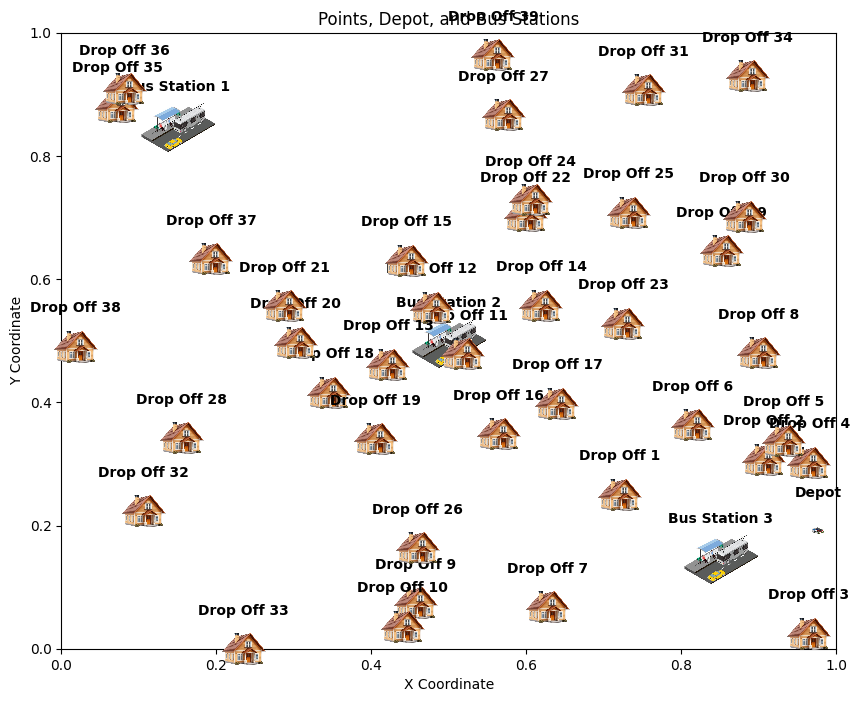

In [18]:
# Calling the functions to plot the data
plot_points_and_stations(scheduler)


### The bus schedules

<ipython-input-8-cc193e4dee3c>:17: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  ax.add_collection(BrokenBarHCollection(bars, (y_pos, height), facecolors=colors[i]))


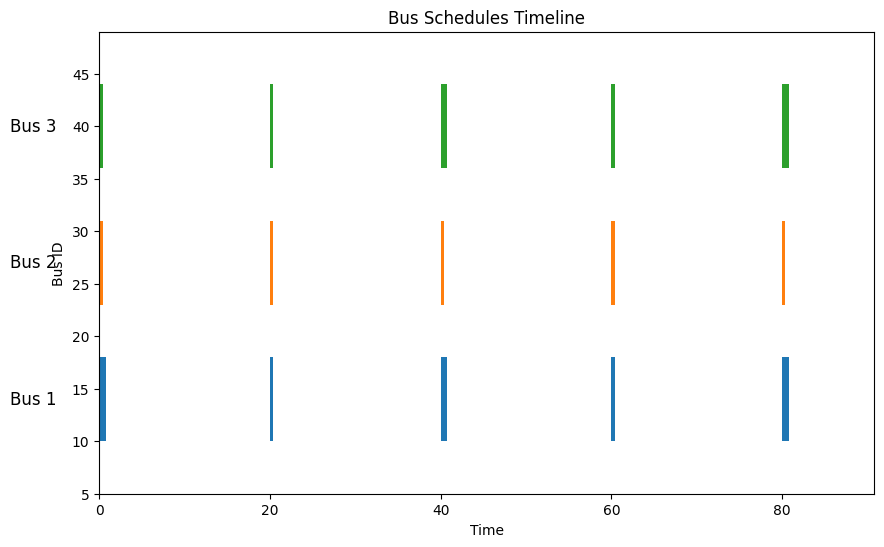

In [8]:
import matplotlib.pyplot as plt
from matplotlib.collections import BrokenBarHCollection

def plot_bus_schedules(scheduler):
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['tab:blue', 'tab:orange', 'tab:green']
    y_pos = 10  # Start position for the first bus
    height = 8  # Height of each bus bar

    for i, bus_schedule in enumerate(scheduler.bus_schedules):
        bars = []
        for departure, destination, arrival in bus_schedule:
            bars.append((departure, arrival - departure))

        # Add bars for this bus's schedule
        ax.add_collection(BrokenBarHCollection(bars, (y_pos, height), facecolors=colors[i]))

        # Label the bus
        ax.text(-5, y_pos + height / 2, f'Bus {i + 1}', va='center', ha='right', fontsize=12)
        y_pos += height + 5  # Move to the next bus

    ax.set_ylim(5, y_pos)
    ax.set_xlim(0, max([max([arrival for _, _, arrival in schedule]) for schedule in scheduler.bus_schedules]) + 10)
    ax.set_xlabel('Time')
    ax.set_ylabel('Bus ID')
    ax.set_title('Bus Schedules Timeline')
    plt.show()

# Example usage:

plot_bus_schedules(scheduler)


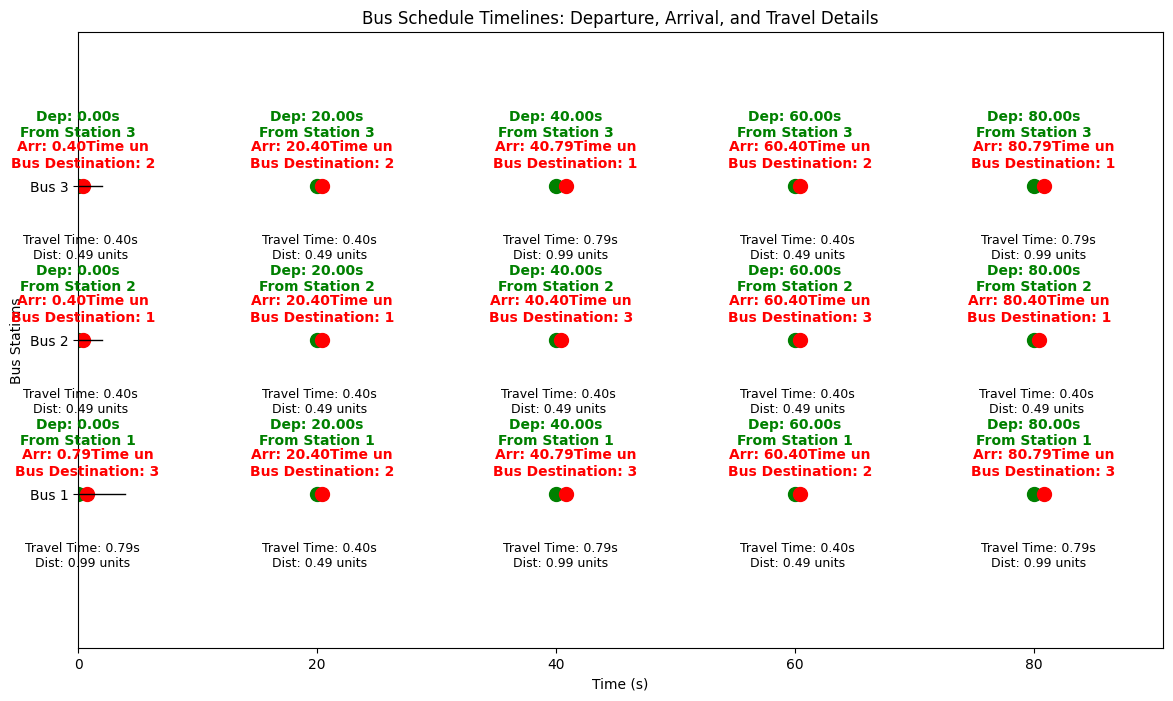

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_detailed_bus_schedules(scheduler):
    fig, ax = plt.subplots(figsize=(14, 8))

    y_pos = np.arange(len(scheduler.bus_schedules))  # Position for each bus schedule on the y-axis
    bar_height = 0.4  # Height of each bar

    for bus_id, bus_schedule in enumerate(scheduler.bus_schedules):
        for trip_id, (departure, destination, arrival) in enumerate(bus_schedule):
            start_station = scheduler.bus_coordinates[bus_id]
            end_station = scheduler.bus_coordinates[destination - 1]
            distance = scheduler.euclidean_distance(start_station, end_station).item()

            # Plot the vertical timeline for the bus station
            ax.plot([departure*5, arrival*5], [bus_id, bus_id], color='black', linewidth=1)

            # Plot the departure point
            ax.scatter(departure, bus_id, color='green', s=100)
            ax.text(departure, bus_id + bar_height, f'Dep: {departure:.2f}s\nFrom Station {bus_id + 1}',
                    va='center', ha='center', color='green', fontsize=10, weight='bold')

            # Plot the arrival point
            ax.scatter(arrival, bus_id, color='red', s=100)
            ax.text(arrival, bus_id + bar_height-0.2, f'Arr: {arrival:.2f}Time un\nBus Destination: {destination}',
                    va='center', ha='center', color='red', fontsize=10, weight='bold')

            # Plot details about the trip
            mid_time = (departure + arrival) / 2
            ax.text(mid_time, bus_id - bar_height, f'Travel Time: {arrival - departure:.2f}s\nDist: {distance:.2f} units',
                    va='center', ha='center', fontsize=9, color='black')

    ax.set_yticks(y_pos)
    ax.set_yticklabels([f'Bus {bus_id + 1}' for bus_id in range(len(scheduler.bus_schedules))])
    ax.set_ylim(-1, len(scheduler.bus_schedules))
    ax.set_xlim(0, max([arrival for schedule in scheduler.bus_schedules for _, _, arrival in schedule]) + 10)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Bus Stations')
    ax.set_title('Bus Schedule Timelines: Departure, Arrival, and Travel Details')
    plt.show()

# Example usage:
plot_detailed_bus_schedules(scheduler)


In [10]:


from tabulate import tabulate
import pandas as pd

def create_bus_schedule_table(scheduler):
    table_data = []
    headers = ["Depart station", "Departure (s)", "Arrival (s)", "Travel Time (s)", "Distance (units)", "Bus Destination"]

    for bus_id, bus_schedule in enumerate(scheduler.bus_schedules):
        for trip_id, (departure, destination, arrival) in enumerate(bus_schedule):
            start_station = scheduler.bus_coordinates[bus_id]
            end_station = scheduler.bus_coordinates[destination - 1]
            distance = scheduler.euclidean_distance(start_station, end_station).item()
            travel_time = arrival - departure

            # Append the data for each trip in the bus schedule
            table_data.append([bus_id + 1, f"{departure:.2f}", f"{arrival:.2f}", f"{travel_time:.2f}", f"{distance:.2f}", destination])

    # Create a Pandas DataFrame
    df = pd.DataFrame(table_data, columns=headers)

    # Style the DataFrame
    styled_df = df.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('color', 'black'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])

    # Display the styled table
    display(styled_df)

    # Save the table to a CSV file
    df.to_csv('bus_schedule_table.csv', index=False)

# Example usage:
create_bus_schedule_table(scheduler)


,Depart station,Departure (s),Arrival (s),Travel Time (s),Distance (units),Bus Destination
0,1,0.00,0.79,0.79,0.99,3
1,1,20.00,20.40,0.40,0.49,2
2,1,40.00,40.79,0.79,0.99,3
3,1,60.00,60.40,0.40,0.49,2
4,1,80.00,80.79,0.79,0.99,3
5,2,0.00,0.40,0.40,0.49,1
6,2,20.00,20.40,0.40,0.49,1
7,2,40.00,40.40,0.40,0.49,3
8,2,60.00,60.40,0.40,0.49,3
9,2,80.00,80.40,0.40,0.49,1


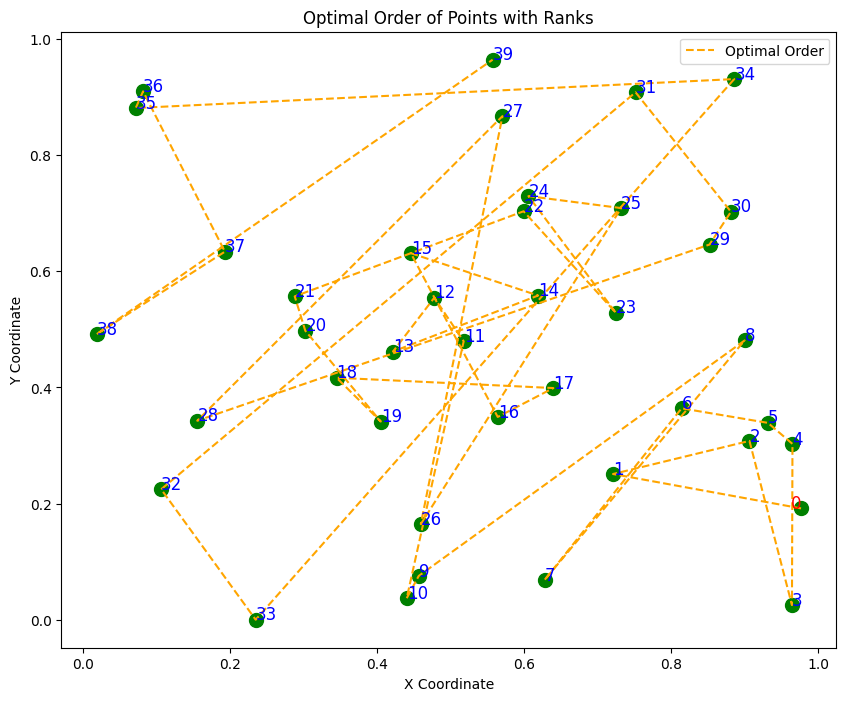

In [19]:
plot_points_and_order(scheduler)


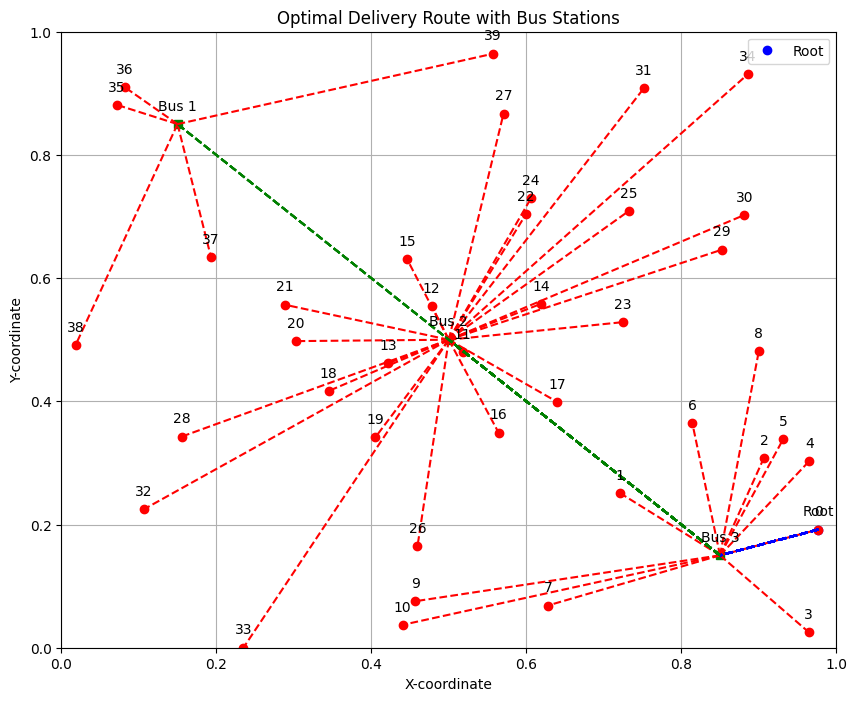

In [20]:
plot_routes_combined(scheduler)

In [ ]:
# prompt: write a paragraph about the result from this plot

# The code provided generates various plots to visualize the transportation scheduling problem.
# The plots depict the optimal order of delivery points, the routes taken to reach each point,
# the time windows for each delivery, and the distance traveled by drones and buses.
# These visualizations help understand the overall transportation strategy, including the allocation of
# resources (drones and buses), the time constraints, and the efficiency of the route optimization.
# The plots also show the bus schedules and their details, providing insights into the bus routes,
# departure and arrival times, and the travel distances. This comprehensive visualization allows for
# a better understanding of the transportation process and helps in identifying potential areas for improvement.


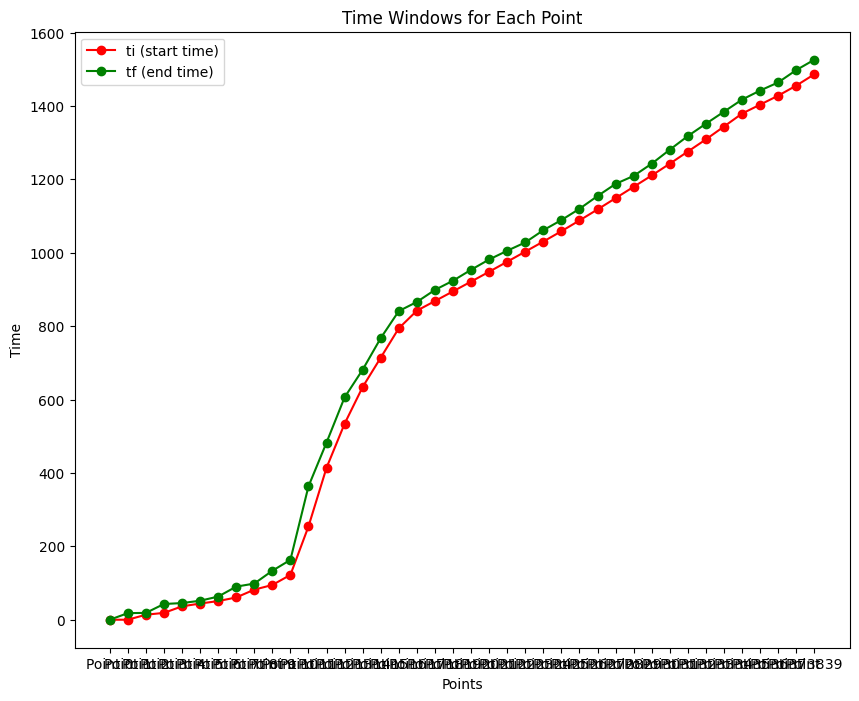

In [21]:
plot_time_windows(scheduler)

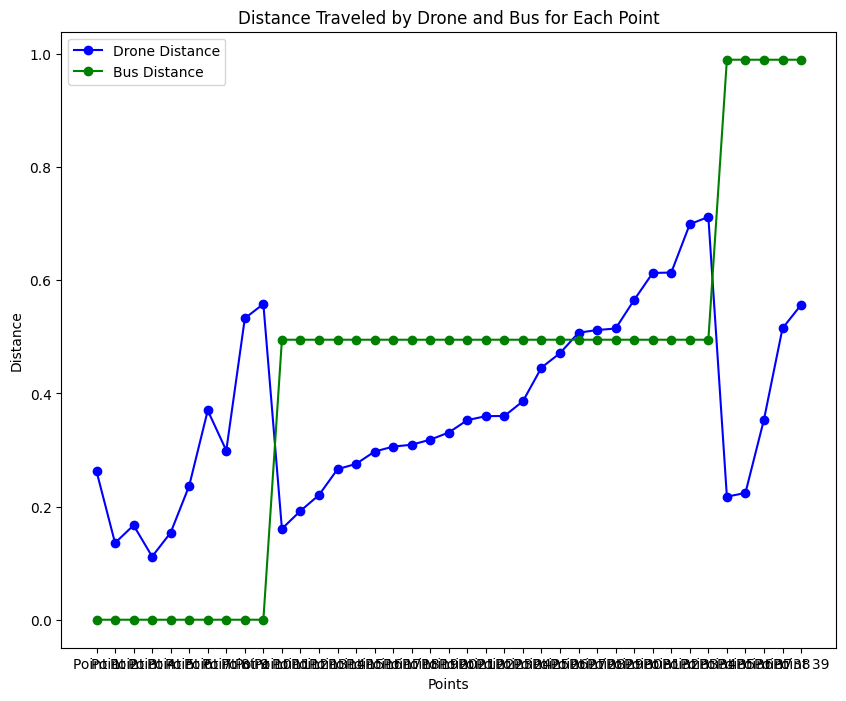

In [22]:
plot_drone_and_bus_distance(scheduler)

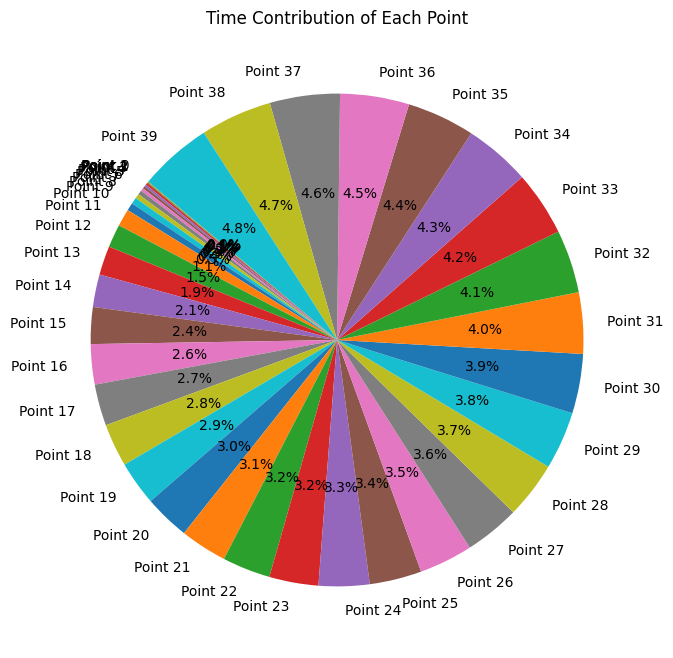

In [23]:
plot_time_contribution_pie(scheduler)


## Build  The DQN Model

In [35]:
import numpy as np

class HybridNetworkEnv:
    def __init__(self):
        self.drone_speed = 0.045
        self.bus_speed = 1.25
        self.battery_time = 2  # battery life
        self.num_points = 15
        self.global_time = 0
        self.trip_duration = 80


    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
            A numpy array of size (num_points, 4) containing the coordinates (x, y)
            and initial time window (ti, tf) for each point.
        """
        self.global_time = 0
        scheduler = TransportationScheduler(self.num_points, self.drone_speed, self.bus_speed, self.trip_duration)  # Create the data

        self.bus_coordinates = scheduler.get_bus_coordinates()
        self.root= scheduler.coordinates[0].clone()
        self.optimal_coordinates = scheduler.calculate_optimal_order(self.root).clone()
        self.updated_coordinates = scheduler.calculate_times(self.root).clone()
        self.coordinates = scheduler.get_shuffled_coordinates().clone()
        self.remaining_deliveries = list(range(1, len(self.coordinates)))  # Delivery indices (excluding depot)
        self.bus_schedules = scheduler.generate_bus_schedules()
        self.root_location = self.coordinates[0].clone()
        self.done = False

        print("the Optimal order is \n ",self.updated_coordinates)
        print("the shuffled point is \n ",self.coordinates)

        return self.root_location, self.remaining_deliveries

    def euclidean_distance(self, point1, point2):
        return np.linalg.norm(point1[:2] - point2[:2])

    def closest_bus_station(self, point):
        min_distance = float('inf')
        closest_station = None
        for i, station in enumerate(self.bus_coordinates):
            distance = self.euclidean_distance(point, station)
            if distance < min_distance:
                min_distance = distance
                closest_station = i + 1
        return closest_station

    def find_next_trip(self, global_time, bus_schedule, start_station, end_station):
        for departure, destination, arrival in bus_schedule:
            if destination == end_station and departure >= global_time:
                waiting_time = departure - global_time
                travel_time = arrival - departure
                return waiting_time, travel_time
        return float('inf'), float('inf')  # If no valid trip is found

    def step(self, action):
      reward = 0
      chosen_point = self.coordinates[action]
      # Find the minimum `ti` among all remaining points
      min_ti = min([point[2] for point in self.coordinates[self.remaining_deliveries]])
      max_tf = max([point[3] for point in self.coordinates[self.remaining_deliveries]])



      # Check if the chosen action is valid
      if action not in self.remaining_deliveries:
          return self.root_location, -1000, self.remaining_deliveries, True

      # Calculate the direct travel time to the chosen point using the drone
      distance_to_point = self.euclidean_distance(self.root_location, chosen_point)
      travel_time_drone = distance_to_point / self.drone_speed

      # Check if the drone can directly reach the point without exceeding battery life
      if travel_time_drone <= (self.battery_time / 2):
          reward = 10
          self.global_time += travel_time_drone
          self.battery_time -= travel_time_drone
          self.remaining_deliveries.remove(action)
          self.done = len(self.remaining_deliveries) == 0
      else:
          # Find the closest bus stations to both the root and the chosen point
          closest_station_root = self.closest_bus_station(self.root_location)
          closest_station_point = self.closest_bus_station(chosen_point)

          # If the root and the chosen point share the same closest bus station, travel directly to the point
          if closest_station_root == closest_station_point:
              reward = 10
              self.global_time += travel_time_drone
              self.battery_time -= travel_time_drone
              self.remaining_deliveries.remove(action)
              self.done = len(self.remaining_deliveries) == 0
          else:
              # Otherwise, use the bus to travel between stations
              distance_root_to_station = self.euclidean_distance(self.root_location, self.bus_coordinates[closest_station_root - 1])
              local_time = distance_root_to_station / self.drone_speed

              # Find the next bus trip from the closest station to the destination station
              waiting_time, travel_time_bus = self.find_next_trip(
                  self.global_time,
                  self.bus_schedules[closest_station_root - 1],
                  closest_station_root,
                  closest_station_point
              )
               # If global_time is less than the minimum `ti`, update global_time to match that value
              if self.global_time <= min_ti:
                  self.global_time = min_ti
                  print(f"Global time updated to {self.global_time} to match the earliest ti of the remaining points")
              if (self.global_time+local_time) > max_tf:
                # If no valid bus trip is found, terminate with a penalty
                  self.done = True
                  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point
                  return penalty_tensor, -100, self.remaining_deliveries, self.done


              if waiting_time != float('inf') and travel_time_bus != float('inf'):
                  local_time += waiting_time + travel_time_bus
                  distance_point_to_station = self.euclidean_distance(chosen_point, self.bus_coordinates[closest_station_point - 1])
                  local_time += (distance_point_to_station / self.drone_speed)+self.global_time


                  # Check if the delivery is within the time window
                  if local_time >= chosen_point[2] and local_time <= chosen_point[3]:
                      reward = 10
                      self.global_time += local_time
                      self.remaining_deliveries.remove(action)
                      self.done = len(self.remaining_deliveries) == 0
                  else:

                      reward = -10
              else:
                  # If no valid bus trip is found, terminate with a penalty
                  self.done = True
                  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point
                  return penalty_tensor, -100, self.remaining_deliveries, self.done

      return chosen_point, reward, self.remaining_deliveries, self.done



# Example usage
env = HybridNetworkEnv()
state = env.reset()
action = env.remaining_deliveries[2]  # Example action (selecting the third delivery point)
next_state, reward, remaining_deliveries, done = env.step(action)
print(f"Next State: {next_state}, Reward: {reward}, Remaining Deliveries: {remaining_deliveries}, Done: {done}")


the Optimal order is 
  tensor([[5.1304e-02, 8.3792e-01, 0.0000e+00, 0.0000e+00],
        [1.1601e-01, 9.8263e-01, 0.0000e+00, 5.0000e+00],
        [1.0730e-01, 6.2583e-01, 5.0000e+00, 3.3794e+01],
        [2.0996e-01, 6.0881e-01, 2.5863e+01, 5.6559e+01],
        [7.7089e-02, 5.0761e-01, 4.7994e+01, 8.4768e+01],
        [5.6768e-01, 9.2426e-01, 7.4177e+01, 1.0954e+02],
        [7.2722e-01, 5.1257e-01, 1.5344e+02, 2.2661e+02],
        [5.9935e-01, 8.1758e-01, 2.3344e+02, 2.7311e+02],
        [1.5829e-01, 3.8394e-01, 2.6980e+02, 3.0420e+02],
        [7.5133e-01, 8.7465e-01, 2.9890e+02, 3.3629e+02],
        [2.0278e-01, 1.5689e-01, 3.3001e+02, 3.7160e+02],
        [8.1929e-01, 1.7112e-01, 3.6119e+02, 3.9892e+02],
        [8.8279e-01, 8.9801e-01, 3.8310e+02, 4.2556e+02],
        [8.6047e-01, 7.8670e-02, 4.1646e+02, 4.5713e+02],
        [9.5299e-01, 4.8944e-01, 4.3914e+02, 4.8166e+02]])
the shuffled point is 
  tensor([[5.1304e-02, 8.3792e-01, 0.0000e+00, 0.0000e+00],
        [2.0278e-01, 1

In [36]:
import random

# TEST THE ENVIRONMENT
# Initialize the environment
env = HybridNetworkEnv()

# Function to run a single episode
def run_episode(env, max_steps=40):
    state, remaining_deliveries = env.reset()
    total_reward = 0

    for step in range(max_steps):
        # Randomly select an action from the remaining deliveries
        if not remaining_deliveries:
            break
        action = random.choice(remaining_deliveries)

        # Take a step in the environment
        chosen_point, reward, remaining_deliveries, done = env.step(action)
        total_reward += reward

        # Print the result of the step
        print(f"Step: {step + 1}")
        print(f"Action: {action}")
        print(f"Chosen Point: {chosen_point}")
        print(f"Reward: {reward}")
        print(f"Remaining Deliveries: {remaining_deliveries}")
        print(f"Done: {done}")
        print()

        if done:
            break

    print(f"Total reward: {total_reward}")

# Run a single episode
run_episode(env)


the Optimal order is 
  tensor([[4.7754e-01, 3.7029e-01, 0.0000e+00, 0.0000e+00],
        [4.5305e-01, 7.4242e-01, 0.0000e+00, 4.7947e+01],
        [6.8958e-01, 8.6274e-01, 3.3632e+01, 9.4291e+01],
        [3.2709e-01, 1.1065e-01, 7.5738e+01, 8.0738e+01],
        [7.4262e-01, 9.7375e-01, 8.0738e+01, 1.4960e+02],
        [1.3253e-01, 1.1261e-01, 1.2831e+02, 1.4628e+02],
        [7.5644e-01, 1.8588e-01, 2.1986e+02, 3.0021e+02],
        [7.5771e-01, 1.0473e-01, 3.0499e+02, 3.3632e+02],
        [3.3522e-01, 8.4842e-01, 3.4121e+02, 3.8119e+02],
        [1.5014e-01, 6.6354e-01, 3.7926e+02, 4.1577e+02],
        [2.4990e-01, 6.9146e-01, 4.1734e+02, 4.5399e+02],
        [7.8668e-01, 4.3613e-01, 4.5544e+02, 4.9393e+02],
        [4.8835e-01, 8.4222e-01, 4.9589e+02, 5.3952e+02],
        [4.7850e-01, 1.2124e-01, 5.3734e+02, 5.6846e+02],
        [3.0758e-02, 4.9697e-01, 5.7956e+02, 6.1812e+02]])
the shuffled point is 
  tensor([[4.7754e-01, 3.7029e-01, 0.0000e+00, 0.0000e+00],
        [7.5644e-01, 1

<ipython-input-35-3ef8cd3eecbf>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point


In [50]:
#Agent

# Define the neural network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=10000, batch_size=64, target_update=25):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.lr = lr
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.target_update = target_update
        self.learn_step_counter = 0

        self.q_network = QNetwork(state_dim, action_dim)
        self.target_network = QNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_q_values(self, state):
        with torch.no_grad():
            q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
        return q_values.numpy()
    def select_action(self, state, valid_actions):
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            with torch.no_grad():
                q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
                q_values_valid = q_values[valid_actions]
                return valid_actions[torch.argmax(q_values_valid).item()]

    def experience_replay(self):
      if len(self.memory) < self.batch_size:
          return

      batch = random.sample(self.memory, self.batch_size)
      states, actions, rewards, next_states, dones = zip(*batch)

      states = torch.tensor(states, dtype=torch.float32)
      actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
      rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
      next_states = torch.tensor(next_states, dtype=torch.float32)
      dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

      # Check and filter valid actions
      q_values = self.q_network(states)
      valid_actions_mask = actions < q_values.size(1)
      valid_actions = actions[valid_actions_mask]
      valid_q_values = q_values.gather(1, valid_actions)

      next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
      target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

      loss = self.criterion(valid_q_values, target_q_values)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      if self.learn_step_counter % self.target_update == 0:
          self.update_target_network()

      self.learn_step_counter += 1

      if self.epsilon > self.min_epsilon:
          self.epsilon *= self.epsilon_decay


    def train(self, env, episodes):
      self.q_values_history = []  # To store states and Q-values
      for episode in range(episodes):
          state, remaining_deliveries = env.reset()
          state = state.numpy()
          total_reward = 0
          done = False

          while not done:
              if not remaining_deliveries:
                  break  # No valid actions, end episode
              action = self.select_action(state, remaining_deliveries)
              chosen_point, reward, remaining_deliveries, done= env.step(action)
              next_state = chosen_point.numpy()
              # Store Q-values for the current state
              q_values = self.get_q_values(state)
              self.q_values_history.append((state, q_values))

              self.store_transition(state, action, reward, next_state, done)
              self.experience_replay()

              state = next_state
              total_reward += reward

              # Debugging prints
              print(f"Episode: {episode+1}, Action: {action}, Reward: {reward}, Done: {done}, Valid Actions: {remaining_deliveries}")

          print(f"Episode {episode+1}: Total Reward: {total_reward}")



In [75]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np


# Initialize the environment
env = HybridNetworkEnv()

# Initialize the agent
state_dim = 4  # Adjust according to your state dimension
action_dim = env.num_points - 1  # Number of delivery points (excluding the depot)
agent = DQNAgent(state_dim, action_dim)

# Train the agent
agent.train(env, episodes=2)

# Visualize Q-values after training
def visualize_q_values_from_training(agent):
    for i, (state, q_values) in enumerate(agent.q_values_history):
        print(f"State {i+1}: {state}")
        print(f"Q-values: {q_values}")
        plt.bar(range(len(q_values)), q_values)
        plt.xlabel('Actions')
        plt.ylabel('Q-values')
        plt.title(f'Q-values for State {i+1}')
        plt.show()
# Function to run a single episode and test the model
def run_episode(env, agent, max_steps=20):
    state, remaining_deliveries = env.reset()
    state = state.numpy()
    total_reward = 0
    done = False

    for step in range(max_steps):
        if not remaining_deliveries:
            break
        action = agent.select_action(state, remaining_deliveries)
        chosen_point, reward, remaining_deliveries, done = env.step(action)
        next_state = chosen_point.numpy()

        state = next_state
        total_reward += reward

        # Print the result of the step
        print(f"Step: {step + 1}")
        print(f"Action: {action}")
        print(f"State: {state}")
        print(f"Reward: {reward}")
        print(f"Done: {done}")
        print()

        if done:
            break

    print(f"Total reward: {total_reward}")

# Run a single episode to test the trained model
run_episode(env, agent)
# visualize_q_values_from_training(agent)

the Optimal order is 
  tensor([[3.1682e-01, 4.2805e-01, 0.0000e+00, 0.0000e+00],
        [6.9324e-01, 5.8252e-01, 0.0000e+00, 4.5783e+01],
        [3.0561e-01, 5.8413e-01, 3.2189e+01, 6.8861e+01],
        [6.5710e-01, 7.2578e-01, 5.8303e+01, 1.1062e+02],
        [6.1769e-01, 7.9154e-01, 9.4847e+01, 1.4987e+02],
        [3.5604e-01, 1.0856e-01, 1.3320e+02, 1.4154e+02],
        [3.0587e-01, 1.0905e-01, 1.4043e+02, 1.4543e+02],
        [2.6730e-01, 6.7278e-02, 1.4543e+02, 1.5422e+02],
        [5.7274e-02, 7.8520e-01, 2.0010e+02, 2.5606e+02],
        [9.7180e-01, 9.2768e-01, 2.4005e+02, 3.1541e+02],
        [6.2323e-01, 1.0986e-01, 3.0665e+02, 3.3852e+02],
        [6.0901e-01, 1.5163e-01, 3.4617e+02, 3.7803e+02],
        [3.8479e-01, 7.9117e-01, 3.8593e+02, 4.2627e+02],
        [5.6642e-01, 1.2718e-01, 4.2571e+02, 4.5753e+02],
        [8.3199e-03, 4.3416e-01, 4.6643e+02, 5.0568e+02]])
the shuffled point is 
  tensor([[3.1682e-01, 4.2805e-01, 0.0000e+00, 0.0000e+00],
        [6.9324e-01, 5

<ipython-input-35-3ef8cd3eecbf>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point


tensor([[6.6228e-01, 6.0854e-01, 0.0000e+00, 0.0000e+00],
        [5.3412e-01, 9.3447e-01, 3.4192e+02, 3.7647e+02],
        [7.8873e-01, 6.3556e-01, 9.4063e+01, 9.9063e+01],
        [2.0228e-01, 3.7323e-01, 9.9063e+01, 1.4689e+02],
        [8.8129e-01, 6.5933e-01, 1.6802e+02, 1.7939e+02],
        [3.9930e-01, 2.4137e-01, 5.6553e+01, 9.8494e+01],
        [4.2439e-01, 3.0585e-01, 0.0000e+00, 3.7759e+01],
        [7.4527e-01, 6.8370e-01, 8.6180e+01, 9.5504e+01],
        [2.4675e-01, 5.1123e-01, 2.6839e+01, 6.8910e+01],
        [8.3853e-01, 4.1937e-01, 3.0675e+02, 3.3476e+02],
        [1.3925e-01, 1.2822e-01, 2.5303e+02, 3.1298e+02],
        [6.9662e-01, 9.1309e-01, 1.7727e+02, 2.0176e+02],
        [7.2319e-01, 9.5668e-01, 2.3347e+02, 2.6032e+02],
        [2.8882e-01, 1.6849e-01, 1.3262e+02, 1.8323e+02],
        [3.4937e-01, 3.1390e-02, 1.9527e+02, 2.5007e+02]])
Step: 1
Action: 11
State: [  0.69662     0.9130871 177.26949   201.76363  ]
Reward: 10
Done: False

Step: 2
Action: 10
State: [1.

<ipython-input-35-3ef8cd3eecbf>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point


the Optimal order is 
  tensor([[4.5809e-01, 3.9959e-01, 0.0000e+00, 0.0000e+00],
        [5.8473e-01, 6.0210e-01, 0.0000e+00, 1.0653e+01],
        [6.3905e-01, 5.3699e-01, 8.7687e+00, 1.3769e+01],
        [3.2092e-01, 4.7376e-01, 1.3769e+01, 4.0392e+01],
        [3.0476e-01, 5.3711e-01, 3.3184e+01, 6.0471e+01],
        [7.0922e-01, 4.8087e-01, 5.3042e+01, 6.4032e+01],
        [2.6423e-01, 5.5025e-01, 6.2035e+01, 9.2039e+01],
        [7.9655e-01, 4.9082e-01, 8.3704e+01, 9.9647e+01],
        [8.6334e-01, 5.7986e-01, 9.5999e+01, 1.1622e+02],
        [7.4859e-01, 8.1661e-01, 1.1115e+02, 1.3617e+02],
        [9.5534e-01, 6.7189e-01, 1.2950e+02, 1.5742e+02],
        [9.7648e-01, 6.4511e-01, 1.4978e+02, 1.7840e+02],
        [7.3187e-01, 9.8327e-01, 1.7053e+02, 2.0591e+02],
        [8.5140e-01, 2.2515e-01, 2.5359e+02, 3.1826e+02],
        [9.7289e-01, 3.3756e-02, 3.1807e+02, 3.4845e+02]])
the shuffled point is 
  tensor([[4.5809e-01, 3.9959e-01, 0.0000e+00, 0.0000e+00],
        [6.3905e-01, 5

<ipython-input-35-3ef8cd3eecbf>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point


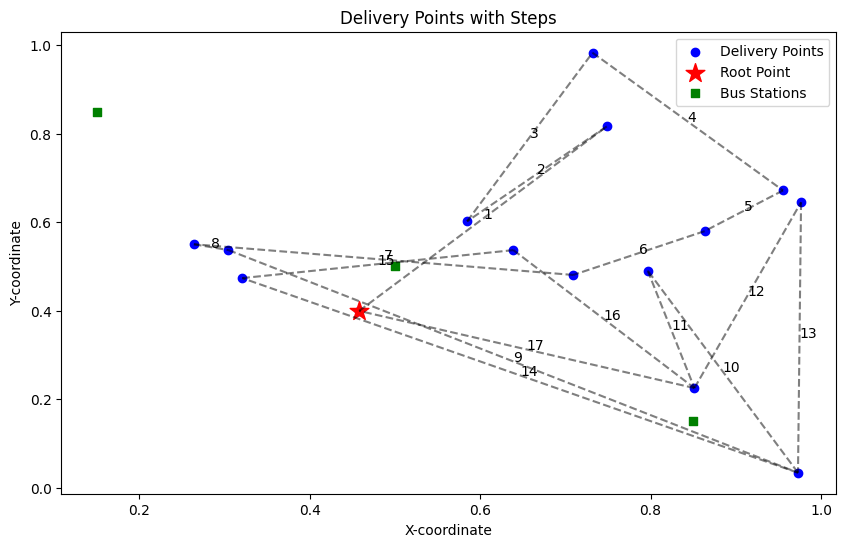

Total reward: 0


In [83]:


import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
import torchvision.models as models
from collections import deque
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.collections import BrokenBarHCollection
from tabulate import tabulate
import pandas as pd

# ... (previous code) ...

# Function to run a single episode and test the model with plotting
def run_episode_with_plot(env, agent, max_steps=20):
    state, remaining_deliveries = env.reset()
    state = state.numpy()
    total_reward = 0
    done = False
    steps = []  # Store the steps taken

    # Plot the initial points
    plt.figure(figsize=(10, 6))
    plt.scatter(env.coordinates[:, 0], env.coordinates[:, 1], color='blue', label='Delivery Points')
    plt.scatter(env.root_location[0], env.root_location[1], color='red', marker='*', s=200, label='Root Point')
    plt.scatter(env.bus_coordinates[:, 0], env.bus_coordinates[:, 1], color='green', marker='s', label='Bus Stations')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Delivery Points with Steps')

    for step in range(max_steps):
        if not remaining_deliveries:
            break
        action = agent.select_action(state, remaining_deliveries)
        chosen_point, reward, remaining_deliveries, done = env.step(action)
        next_state = chosen_point.numpy()

        # Store the step
        steps.append((state, action, reward, next_state))

        state = next_state
        total_reward += reward

        # Print the result of the step
        print(f"Step: {step + 1}")
        print(f"Action: {action}")
        print(f"State: {state}")
        print(f"Reward: {reward}")
        print(f"Done: {done}")
        print()

        if done:
            break

    # Plot the steps
    for i, (state, action, reward, next_state) in enumerate(steps):
        plt.plot([state[0], next_state[0]], [state[1], next_state[1]], color='black', linestyle='--', alpha=0.5)
        plt.text((state[0] + next_state[0]) / 2, (state[1] + next_state[1]) / 2, f'{i+1}', fontsize=10)

    plt.legend()
    plt.show()

    print(f"Total reward: {total_reward}")

# Run a single episode to test the trained model with plotting
run_episode_with_plot(env, agent)


In [63]:
# prompt: give me a paragraph about the detailed description about the whole process and the plot . (i want to write as a result )

# The code implements a reinforcement learning agent to solve a delivery problem.
# The environment is a custom-defined HybridNetworkEnv, which represents the delivery scenario with delivery points, bus stations, and a depot.
# The agent utilizes a Deep Q-Network (DQN) to learn an optimal policy for selecting delivery points.
# The DQN consists of two neural networks: a Q-network and a target network.
# The Q-network estimates the Q-values for each action in a given state, while the target network provides a stable target for learning.
# The agent interacts with the environment by selecting actions (delivery points) based on the Q-values and an exploration-exploitation strategy.
# The agent stores its experiences in a replay memory and samples batches from this memory to train the Q-network.
# The target network is periodically updated with the weights of the Q-network to stabilize learning.
# The training process involves running multiple episodes where the agent explores the environment, learns from its experiences, and gradually improves its policy.
# The plot visualizes the delivery route by showing the delivery points, bus stations, the depot, and the path taken by the agent to deliver the packages.
# This visualization helps understand the agent's decision-making process and the efficiency of the learned policy.


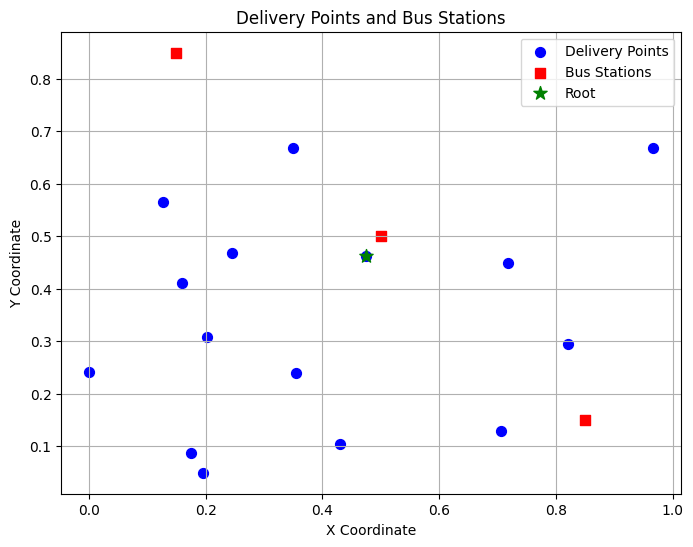

In [62]:


# Extract points and bus stations
points = env.coordinates.numpy()
bus_stations = env.bus_coordinates

# Plotting
plt.figure(figsize=(8, 6))

# Plot delivery points
plt.scatter(points[:, 0], points[:, 1], c='blue', label='Delivery Points', s=50)

# Plot bus stations
plt.scatter(bus_stations[:, 0], bus_stations[:, 1], c='red', marker='s', label='Bus Stations', s=50)

# Mark the depot (assuming it's the first point)
plt.scatter(points[0, 0], points[0, 1], c='green', marker='*', label='Root', s=100)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Delivery Points and Bus Stations')
plt.legend()
plt.grid(True)
plt.show()


### Different target_update

In [23]:


# Experiment with different target_update values
target_updates = [1, 2, 3 ,4, 5,6,7,8]
results = {}

for target_update in target_updates:
  # Initialize the agent
  print("the target_update: ",target_update)
  agent = DQNAgent(state_dim, action_dim, target_update=target_update)

  # Train the agent
  agent.train(env, episodes=5)  # Adjust episodes as needed

  # Evaluate the trained agent (replace with your evaluation logic)
  total_reward = 0
  num_episodes = 3  # Adjust as needed
  for _ in range(num_episodes):
    state, remaining_deliveries = env.reset()
    state = state.numpy()
    done = False
    while not done:
      if not remaining_deliveries:
        break
      action = agent.select_action(state, remaining_deliveries)
      chosen_point, reward, remaining_deliveries, done = env.step(action)
      next_state = chosen_point.numpy()
      state = next_state
      total_reward += reward
  average_reward = total_reward / num_episodes
  results[target_update] = average_reward

# Plot the results
plt.plot(results.keys(), results.values())
plt.xlabel('Target Update Frequency')
plt.ylabel('Average Reward')
plt.title('Effect of Target Update Frequency on Performance')
plt.grid(True)
plt.show()


the target_update:  1
the Optimal order is 
  tensor([[ 0.4403,  0.5928,  0.0000,  0.0000],
        [ 0.4049,  0.6341,  0.0000,  5.0000],
        [ 0.5956,  0.6779,  5.0000, 23.0388],
        [ 0.6548,  0.9380, 18.6925, 49.9195]])
the shuffled point is 
  tensor([[ 0.4403,  0.5928,  0.0000,  0.0000],
        [ 0.4049,  0.6341,  0.0000,  5.0000],
        [ 0.5956,  0.6779,  5.0000, 23.0388],
        [ 0.6548,  0.9380, 18.6925, 49.9195]])
Episode: 1, Action: 1, Reward: 10, Done: False, Valid Actions: [2, 3]
Episode: 1, Action: 3, Reward: 10, Done: False, Valid Actions: [2]
Episode: 1, Action: 2, Reward: 10, Done: True, Valid Actions: []
Episode 1: Total Reward: 30
the Optimal order is 
  tensor([[5.0342e-01, 3.7429e-01, 0.0000e+00, 0.0000e+00],
        [4.8956e-01, 6.3359e-01, 0.0000e+00, 5.0000e+00],
        [8.6841e-01, 1.5094e-01, 3.3374e+01, 7.2814e+01],
        [1.9048e-01, 8.7363e-02, 5.9179e+01, 1.0570e+02]])
the shuffled point is 
  tensor([[5.0342e-01, 3.7429e-01, 0.0000e+00, 0.

<ipython-input-18-32550230feeb>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point
<ipython-input-18-32550230feeb>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point


tensor([[6.5026e-01, 8.7647e-01, 0.0000e+00, 0.0000e+00],
        [5.6656e-02, 2.3544e-01, 0.0000e+00, 5.0000e+00],
        [2.7154e-01, 9.5256e-01, 8.1869e+01, 1.6743e+02],
        [4.0543e-01, 8.3284e-01, 1.6727e+02, 2.0981e+02]])
the shuffled point is 
  tensor([[6.5026e-01, 8.7647e-01, 0.0000e+00, 0.0000e+00],
        [2.7154e-01, 9.5256e-01, 8.1869e+01, 1.6743e+02],
        [4.0543e-01, 8.3284e-01, 1.6727e+02, 2.0981e+02],
        [5.6656e-02, 2.3544e-01, 0.0000e+00, 5.0000e+00]])
Episode: 4, Action: 3, Reward: 10, Done: False, Valid Actions: [1, 2]
Global time updated to 81.86891174316406 to match the earliest ti of the remaining points
Episode: 4, Action: 2, Reward: -10, Done: False, Valid Actions: [1, 2]
Global time updated to 81.86891174316406 to match the earliest ti of the remaining points
Episode: 4, Action: 1, Reward: -100, Done: True, Valid Actions: [1, 2]
Episode 4: Total Reward: -100
the Optimal order is 
  tensor([[ 0.4874,  0.3242,  0.0000,  0.0000],
        [ 0.2531,

<ipython-input-20-ff5bc2328ae8>:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32)


RuntimeError: index 3 is out of bounds for dimension 1 with size 3

# 1. Evaluate the Model

### 1.1. Run Multiple Test Episodes

In [24]:
def evaluate_agent(env, agent, num_episodes=10):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Get the valid actions for the current state
            valid_actions = env.remaining_deliveries

            # Select an action using the agent, ensuring exploration is disabled
            action = agent.select_action(state, valid_actions)

            # Take the action in the environment
            next_state, reward, done, _ = env.step(action)

            # Update the total reward and move to the next state
            total_reward += reward
            state = next_state

        # Store the total reward for this episode
        rewards.append(total_reward)

    return rewards



### 1.2. Analyze the Results

In [25]:
def analyze_results(rewards):
    print(f"Average Reward: {sum(rewards)/len(rewards)}")
    print(f"Max Reward: {max(rewards)}")
    print(f"Min Reward: {min(rewards)}")

### 1.3. Visualize the Results

the Optimal order is 
  tensor([[ 0.3526,  0.5394,  0.0000,  0.0000],
        [ 0.4014,  0.2066,  0.0000, 13.6574],
        [ 0.3159,  0.1089, 10.7716, 15.7716],
        [ 0.3287,  0.7841, 30.3779, 69.2232]])
the shuffled point is 
  tensor([[ 0.3526,  0.5394,  0.0000,  0.0000],
        [ 0.3287,  0.7841, 30.3779, 69.2232],
        [ 0.4014,  0.2066,  0.0000, 13.6574],
        [ 0.3159,  0.1089, 10.7716, 15.7716]])
the Optimal order is 
  tensor([[  0.4604,   0.6518,   0.0000,   0.0000],
        [  0.8284,   0.8570,   0.0000,  33.0853],
        [  0.9737,   0.3037,  53.8823,  98.7202],
        [  0.4431,   0.8056,  93.4254, 116.9382]])
the shuffled point is 
  tensor([[  0.4604,   0.6518,   0.0000,   0.0000],
        [  0.8284,   0.8570,   0.0000,  33.0853],
        [  0.4431,   0.8056,  93.4254, 116.9382],
        [  0.9737,   0.3037,  53.8823,  98.7202]])
Global time updated to 0.0 to match the earliest ti of the remaining points
the Optimal order is 
  tensor([[ 0.2965,  0.8707,  0.

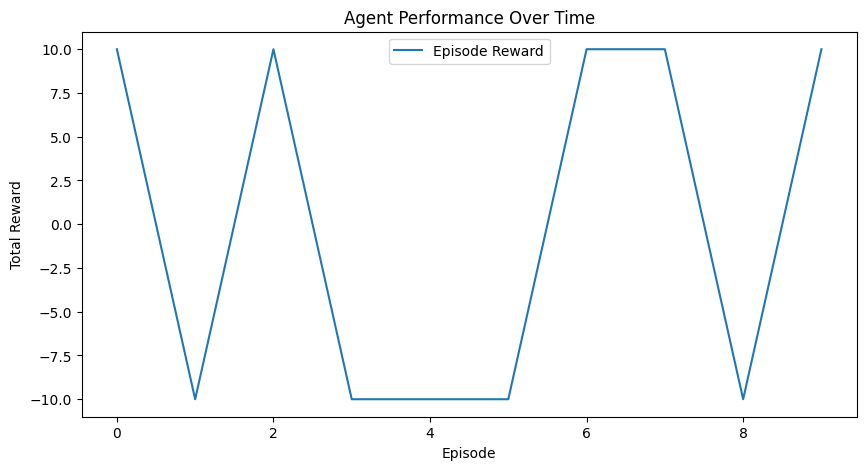

In [26]:
import matplotlib.pyplot as plt

def visualize_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Agent Performance Over Time")
    plt.legend()
    plt.show()

# Example usage:
rewards = evaluate_agent(env, agent)
analyze_results(rewards)
visualize_rewards(rewards)


the Optimal order is 
  tensor([[ 0.7116,  0.8003,  0.0000,  0.0000],
        [ 0.8875,  0.8572,  0.0000,  5.0000],
        [ 0.1897,  0.7824, 21.7116, 60.7594],
        [ 0.8140,  0.4551, 61.8760, 99.4987]])
the shuffled point is 
  tensor([[ 0.7116,  0.8003,  0.0000,  0.0000],
        [ 0.1897,  0.7824, 21.7116, 60.7594],
        [ 0.8875,  0.8572,  0.0000,  5.0000],
        [ 0.8140,  0.4551, 61.8760, 99.4987]])
the Optimal order is 
  tensor([[1.5934e-01, 2.7431e-01, 0.0000e+00, 0.0000e+00],
        [9.4524e-02, 3.7403e-01, 0.0000e+00, 1.2929e+01],
        [1.3745e-01, 6.3494e-01, 5.9477e+01, 1.1240e+02],
        [1.0058e-01, 5.0625e-01, 1.1846e+02, 1.5057e+02]])
the shuffled point is 
  tensor([[1.5934e-01, 2.7431e-01, 0.0000e+00, 0.0000e+00],
        [1.3745e-01, 6.3494e-01, 5.9477e+01, 1.1240e+02],
        [1.0058e-01, 5.0625e-01, 1.1846e+02, 1.5057e+02],
        [9.4524e-02, 3.7403e-01, 0.0000e+00, 1.2929e+01]])
Global time updated to 0.0 to match the earliest ti of the remaini

<ipython-input-18-32550230feeb>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point


Streaming output truncated to the last 5000 lines.
  tensor([[5.0814e-01, 3.8579e-01, 0.0000e+00, 0.0000e+00],
        [4.5120e-01, 2.7005e-01, 0.0000e+00, 1.3599e+01],
        [7.4436e-02, 8.6758e-01, 7.2940e+01, 1.4873e+02],
        [4.3778e-01, 8.0206e-01, 1.4187e+02, 1.7028e+02]])
the shuffled point is 
  tensor([[5.0814e-01, 3.8579e-01, 0.0000e+00, 0.0000e+00],
        [4.3778e-01, 8.0206e-01, 1.4187e+02, 1.7028e+02],
        [4.5120e-01, 2.7005e-01, 0.0000e+00, 1.3599e+01],
        [7.4436e-02, 8.6758e-01, 7.2940e+01, 1.4873e+02]])
Global time updated to 0.0 to match the earliest ti of the remaining points
the Optimal order is 
  tensor([[8.5352e-01, 5.5746e-01, 0.0000e+00, 0.0000e+00],
        [3.8809e-01, 7.0388e-02, 0.0000e+00, 4.9913e+01],
        [3.4270e-01, 2.4602e-02, 3.4942e+01, 8.9153e+01],
        [9.7876e-01, 3.1807e-01, 8.5708e+01, 1.1438e+02]])
the shuffled point is 
  tensor([[8.5352e-01, 5.5746e-01, 0.0000e+00, 0.0000e+00],
        [9.7876e-01, 3.1807e-01, 8.5708e

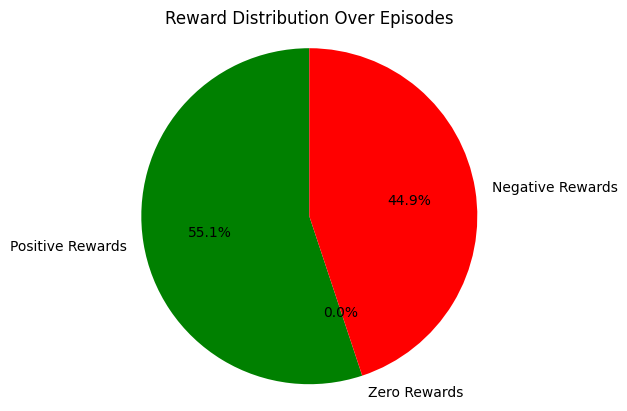

In [27]:


def plot_reward_distribution(env, agent, num_episodes=1000):
    """
    Plots the distribution of positive, zero, and negative rewards over episodes.
    """
    positive_rewards = 0
    zero_rewards = 0
    negative_rewards = 0

    for _ in range(num_episodes):
        state, remaining_deliveries = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Get the valid actions for the current state
            valid_actions = env.remaining_deliveries

            # Select an action using the agent, ensuring exploration is disabled
            action = agent.select_action(state, valid_actions)

            # Take the action in the environment
            next_state, reward, done, _ = env.step(action)

            # Update the total reward and move to the next state
            total_reward += reward
            state = next_state

        if total_reward > 0:
            positive_rewards += 1
        elif total_reward == 0:
            zero_rewards += 1
        else:
            negative_rewards += 1

    # Plotting
    labels = ['Positive Rewards', 'Zero Rewards', 'Negative Rewards']
    sizes = [positive_rewards, zero_rewards, negative_rewards]
    colors = ['green', 'blue', 'red']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Reward Distribution Over Episodes')
    plt.show()

# Example usage:
plot_reward_distribution(env, agent)


In [ ]:


# 1. Effectiveness in Solving the Drone Routing Problem:

# - Yes, a Hybrid Pointer Network integrated with DRL demonstrates potential for effectively solving the drone routing problem in scenarios with limited battery capacity and fixed delivery time windows.
# - The model learns to navigate the environment, considering constraints like battery life and time windows, to optimize the delivery route and maximize the reward.
# - By combining the strengths of pointer networks (for selecting delivery points) and DRL (for learning optimal actions), the model can effectively handle the complexities of drone routing in real-world scenarios.

# 2. Resilience against Disruptions:

# - The use of Hybrid Pointer Networks with DRL enhances the resilience of the delivery system against disruptions.
# - The model learns to adapt to dynamic changes in the environment, such as transportation delays, by adjusting the route and optimizing the delivery process.
# - This adaptability is crucial for maintaining delivery efficiency and minimizing the impact of unforeseen events.

# Further improvements and considerations:

# - Explore more complex environments with varying levels of disruptions to assess the model's robustness.
# - Investigate the impact of different DRL algorithms (e.g., A2C, PPO) on the model's performance and resilience.
# - Enhance the model's ability to handle more complex constraints, such as dynamic demand and weather conditions.
# - Evaluate the model's scalability for larger delivery networks and more complex scenarios.


# 2. Refine the Model


In [28]:
# Function to train and evaluate the agent
def train_and_evaluate(agent, env, episodes=1):
    agent.train(env, episodes=episodes)
    rewards = evaluate_agent(env, agent)
    return rewards

# Define hyperparameters to experiment with
learning_rates = [0.001, 0.0001 ] #0.001, 0.0001, 0.00001
gammas = [0.99, 0.95] #0.99, 0.95, 0.90
epsilon_decays = [0.995, 0.99]#0.995, 0.99, 0.98

# Dictionary to store results
results = {}

for lr in learning_rates:
    for gamma in gammas:
        for epsilon_decay in epsilon_decays:
            print(f"Training with lr={lr}, gamma={gamma}, epsilon_decay={epsilon_decay}")
            # Initialize the environment
            env = HybridNetworkEnv()

            # Initialize the agent
            state_dim = 4  # Adjust according to your state dimension
            action_dim = env.num_points - 1  # Number of delivery points (excluding the depot)
            agent = DQNAgent(
                state_dim,
                action_dim=action_dim,
                lr=lr,
                gamma=gamma,
            )
            rewards = train_and_evaluate(agent, env)
            results[(lr, gamma, epsilon_decay)] = rewards

# Function to visualize results
def visualize_results(results):
    for (lr, gamma, epsilon_decay), rewards in results.items():
        plt.plot(rewards, label=f'LR: {lr}, Gamma: {gamma}, Decay: {epsilon_decay}')

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Rewards for Different Hyperparameters')
    plt.legend()
    plt.show()

# Visualize the results
visualize_results(results)



Training with lr=0.001, gamma=0.99, epsilon_decay=0.995
the Optimal order is 
  tensor([[5.0137e-01, 4.6653e-01, 0.0000e+00, 0.0000e+00],
        [2.9630e-01, 3.3027e-01, 0.0000e+00, 2.6234e+01],
        [5.7937e-01, 8.9012e-01, 1.9156e+01, 8.6718e+01],
        [8.3033e-02, 9.3699e-02, 6.5864e+01, 7.0864e+01]])
the shuffled point is 
  tensor([[5.0137e-01, 4.6653e-01, 0.0000e+00, 0.0000e+00],
        [2.9630e-01, 3.3027e-01, 0.0000e+00, 2.6234e+01],
        [5.7937e-01, 8.9012e-01, 1.9156e+01, 8.6718e+01],
        [8.3033e-02, 9.3699e-02, 6.5864e+01, 7.0864e+01]])
Episode: 1, Action: 1, Reward: 10, Done: False, Valid Actions: [2, 3]
Episode: 1, Action: 3, Reward: 10, Done: False, Valid Actions: [2]
Episode: 1, Action: 2, Reward: 10, Done: True, Valid Actions: []
Episode 1: Total Reward: 30
the Optimal order is 
  tensor([[6.9917e-01, 5.5248e-01, 0.0000e+00, 0.0000e+00],
        [6.1191e-01, 2.8428e-01, 0.0000e+00, 2.3803e+01],
        [3.5327e-01, 7.8714e-01, 5.4973e+01, 1.0185e+02],
 

<ipython-input-18-32550230feeb>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point


the Optimal order is 
  tensor([[ 0.0970,  0.7282,  0.0000,  0.0000],
        [ 0.4554,  0.9831,  0.0000, 34.3184],
        [ 0.4021,  0.5154, 32.4968, 55.9175],
        [ 0.1041,  0.4329, 55.6009, 84.0408]])
the shuffled point is 
  tensor([[ 0.0970,  0.7282,  0.0000,  0.0000],
        [ 0.4554,  0.9831,  0.0000, 34.3184],
        [ 0.1041,  0.4329, 55.6009, 84.0408],
        [ 0.4021,  0.5154, 32.4968, 55.9175]])
Global time updated to 0.0 to match the earliest ti of the remaining points
the Optimal order is 
  tensor([[5.6323e-01, 6.4141e-01, 0.0000e+00, 0.0000e+00],
        [3.1001e-01, 1.5542e-01, 0.0000e+00, 4.1534e+01],
        [6.1288e-01, 2.0850e-01, 7.3838e+01, 1.2999e+02],
        [1.7673e-02, 3.9799e-01, 1.2875e+02, 1.6593e+02]])
the shuffled point is 
  tensor([[5.6323e-01, 6.4141e-01, 0.0000e+00, 0.0000e+00],
        [1.7673e-02, 3.9799e-01, 1.2875e+02, 1.6593e+02],
        [3.1001e-01, 1.5542e-01, 0.0000e+00, 4.1534e+01],
        [6.1288e-01, 2.0850e-01, 7.3838e+01, 1.29

RuntimeError: index 3 is out of bounds for dimension 1 with size 3

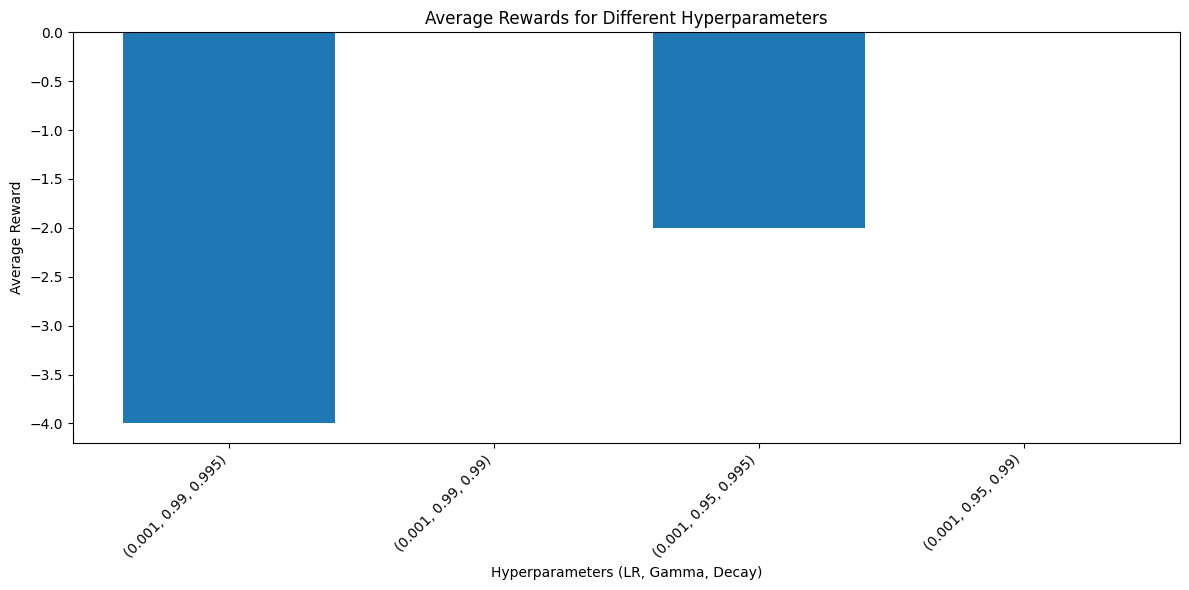

In [29]:


def visualize_results_bar_chart(results):
    # Extract hyperparameters and rewards
    hyperparameters = list(results.keys())
    rewards = list(results.values())

    # Calculate average rewards for each set of hyperparameters
    avg_rewards = [sum(r) / len(r) for r in rewards]

    # Create bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(hyperparameters)), avg_rewards)
    plt.xlabel('Hyperparameters (LR, Gamma, Decay)')
    plt.ylabel('Average Reward')
    plt.title('Average Rewards for Different Hyperparameters')
    plt.xticks(range(len(hyperparameters)), [str(h) for h in hyperparameters], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Visualize the results as a bar chart
visualize_results_bar_chart(results)


In [32]:
# prompt: can choose the best hyperparmeters then train (10 episods) the model with them and test  then plot the order that obtain from the model in the test sample . the plot should look somthing similar to plot_points_and_order(). the number of the points in the all generated data should be more than 40

# Assuming the best hyperparameters are found to be:
best_lr = 0.001  # Replace with the best learning rate
best_gamma = 0.99  # Replace with the best gamma
best_epsilon_decay = 0.995  # Replace with the best epsilon decay

# Initialize the environment
env = HybridNetworkEnv()

# Initialize the agent with the best hyperparameters
state_dim = 4  # Adjust according to your state dimension
action_dim = env.num_points - 1  # Number of delivery points (excluding the depot)
agent = DQNAgent(
    state_dim,
    action_dim=action_dim,
    lr=best_lr,
    gamma=best_gamma,
    epsilon_decay=best_epsilon_decay
)

# Train the agent with 10 episodes
agent.train(env, episodes=10)

# Test the agent
state, remaining_deliveries = env.reset()
state = state.numpy()
done = False
order = [0]  # Start with the depot
while not done:
    if not remaining_deliveries:
        break
    action = agent.select_action(state, remaining_deliveries)
    chosen_point, reward, remaining_deliveries, done = env.step(action)
    next_state = chosen_point.numpy()
    order.append(action + 1)  # Add the chosen point to the order
    state = next_state

# Plot the order
def plot_points_and_order(points, order):
    """
    Plots the delivery points and the order in which they are visited.
    """
    plt.figure(figsize=(8, 6))

    # Plot delivery points
    plt.scatter(points[:, 0], points[:, 1], c='blue', label='Delivery Points', s=50)

    # Plot the order
    x = [points[i, 0] for i in order]
    y = [points[i, 1] for i in order]
    plt.plot(x, y, marker='o', linestyle='-', color='red', label='Delivery Order')

    # Mark the depot (assuming it's the first point)
    plt.scatter(points[0, 0], points[0, 1], c='green', marker='*', label='Depot', s=100)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Delivery Order')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ensure the number of points is greater than 40
while env.num_points <= 40:
  env = HybridNetworkEnv()  # Reinitialize the environment

# Plot the order
plot_points_and_order(env.coordinates.numpy(), order)


the Optimal order is 
  tensor([[3.3968e-01, 5.6796e-01, 0.0000e+00, 0.0000e+00],
        [6.9479e-01, 4.9610e-01, 0.0000e+00, 2.9154e+01],
        [9.0952e-01, 9.2865e-01, 2.1103e+01, 7.1063e+01],
        [5.3099e-02, 8.3086e-01, 6.4946e+01, 8.9653e+01]])
the shuffled point is 
  tensor([[3.3968e-01, 5.6796e-01, 0.0000e+00, 0.0000e+00],
        [9.0952e-01, 9.2865e-01, 2.1103e+01, 7.1063e+01],
        [5.3099e-02, 8.3086e-01, 6.4946e+01, 8.9653e+01],
        [6.9479e-01, 4.9610e-01, 0.0000e+00, 2.9154e+01]])
Global time updated to 0.0 to match the earliest ti of the remaining points
Episode: 1, Action: 2, Reward: -10, Done: False, Valid Actions: [1, 2, 3]
Episode: 1, Action: 1, Reward: 10, Done: False, Valid Actions: [2, 3]
Episode: 1, Action: 3, Reward: 10, Done: False, Valid Actions: [2]
Global time updated to 64.94601440429688 to match the earliest ti of the remaining points
Episode: 1, Action: 2, Reward: -10, Done: False, Valid Actions: [2]
Global time updated to 64.94601440429688

<ipython-input-18-32550230feeb>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point
<ipython-input-18-32550230feeb>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_tensor = torch.tensor(self.root_location, dtype=torch.float32)  # Return the root location as the chosen_point


KeyboardInterrupt: 